Plot the surface temperature field from the IBI model (CMEMS)

In [26]:
import sys
sys.path.insert(0, '..')
import os
import glob
import netCDF4
from filament import filament
import datetime
import cmocean
import logging
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from importlib import reload
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cartopyticker
myproj = ccrs.PlateCarree()
coast = cfeature.GSHHSFeature(scale="f")

In [4]:
logger = logging.getLogger("filamentIBIPlot")
logger.setLevel(logging.INFO)
logging.info("Starting")
plotvis = 0

In [63]:
reload(filament)

<module 'filament.filament' from '../filament/filament.py'>

In [95]:
datadir = "/data/CMEMS/"
figdir = "/data/SST/CapeGhir/figures"
datafilelist = sorted(glob.glob(os.path.join(datadir, "dataset-ibi-analysis-forecast-phys-005-001-hourly_1591963692147.nc")))
nfiles = len(datafilelist)
logger.info("Processing {} files".format(nfiles))

INFO:filamentIBIPlot:Processing 1 files


## Load data

In [100]:
sst = filament.SST()
sst.read_from_cmems(datafilelist[0], 14)

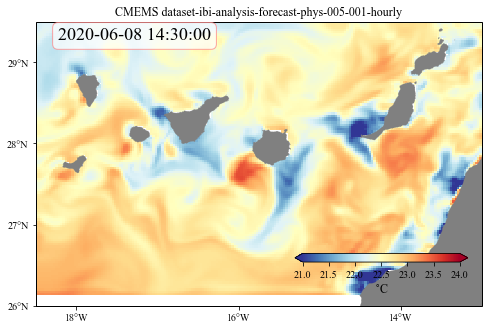

In [102]:
canarydomain = (-18.5, -13., 26., 29.5)
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111, projection=myproj)
plt.title("CMEMS dataset-ibi-analysis-forecast-phys-005-001-hourly")

pcm, cb = sst.add_to_plot(fig, ax, canarydomain, cmap=plt.cm.RdYlBu_r,
                    clim=[21., 24.], vis=False,
                    cbarloc=[0.575, 0.275, 0.3, 0.02], alpha=1)
sst.add_date(ax)
cb.set_ticks(np.arange(21., 24.01, 0.5))
ax.add_feature(coast, linewidth=.2, color=".5")
filament.decorate_map(ax, canarydomain, np.arange(-20., -10., 2.), 
                      np.arange(25., 32., 1.))
plt.savefig(os.path.join(figdir, "SST_CMEMS_20200608"), dpi=300, bbox_inches="tight")
plt.show()

## Compare with SST from satellite

In [103]:
sstfile = "/data/OceanColor/SNPP_VIIRS.20200608T140000.L2.SST.NRT.nc"
sstsat = filament.SST()
sstsat.read_from_oceancolorL2(sstfile)
sstsat.field = np.ma.masked_where(sstsat.qflag > 2, sstsat.field)

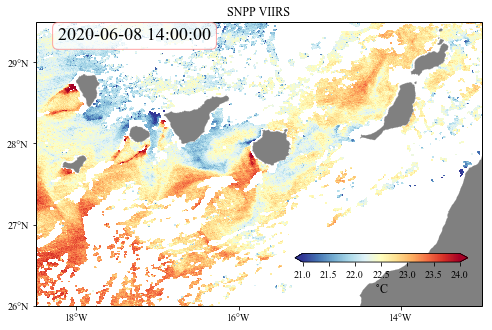

In [104]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111, projection=myproj)
plt.title("SNPP VIIRS")

pcm, cb = sstsat.add_to_plot(fig, ax, canarydomain, cmap=plt.cm.RdYlBu_r,
                    clim=[21., 24.], vis=False,
                    cbarloc=[0.575, 0.275, 0.3, 0.02], alpha=1)
sstsat.add_date(ax)
cb.set_ticks(np.arange(21., 24.01, 0.5))
ax.add_feature(coast, linewidth=.2, color=".5")
filament.decorate_map(ax, canarydomain, np.arange(-20., -10., 2.), 
                      np.arange(25., 32., 1.))
plt.savefig(os.path.join(figdir, "SST_VIIRS_20200608"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()